# Taxi Orders' Prediction
(time series)

## Content

1. [Introduction](#intro)
2. [General information](#general)
3. [Preparing Dataset](#prep)
4. [Models](#models)
5. [Training Best Model on Test Set](#test_set)
8. [Conclusion](#conclusion)



## Introduction<a href='intro'></a>

Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.
The RMSE metric on the test set should not be more than 48.

*Libraries*

In [1]:
'''Basic'''
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

'''Models'''
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression



In [2]:
state=123456

## General Information <a href='general'></a>

In [3]:
try:
    taxi_dataset = pd.read_csv('taxi.csv', index_col='datetime', parse_dates=[0])
except:
    taxi_dataset = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=[0])

In [4]:
taxi_dataset.sample(10, random_state=state)


,num_orders
datetime,
2018-03-23 16:20:00,12
2018-08-28 01:00:00,34
2018-07-24 22:00:00,11
2018-05-11 12:00:00,10
2018-07-24 21:10:00,26
2018-07-02 21:40:00,5
2018-04-06 23:40:00,32
2018-06-26 21:20:00,14
2018-06-13 21:20:00,15


In [5]:
taxi_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
taxi_dataset.isna().sum()

num_orders    0
dtype: int64

In [7]:
taxi_dataset.duplicated().sum()

26415

### Conclusion

We have dataset with 26496 entries and one column plus column with a date(index).<br>
No missing data.<br>
There are duplicates, almost all data. Will work with it.<br>

## Preparing Dataset<a href='prep'></a>

Text(0.5, 1.0, 'Orders')

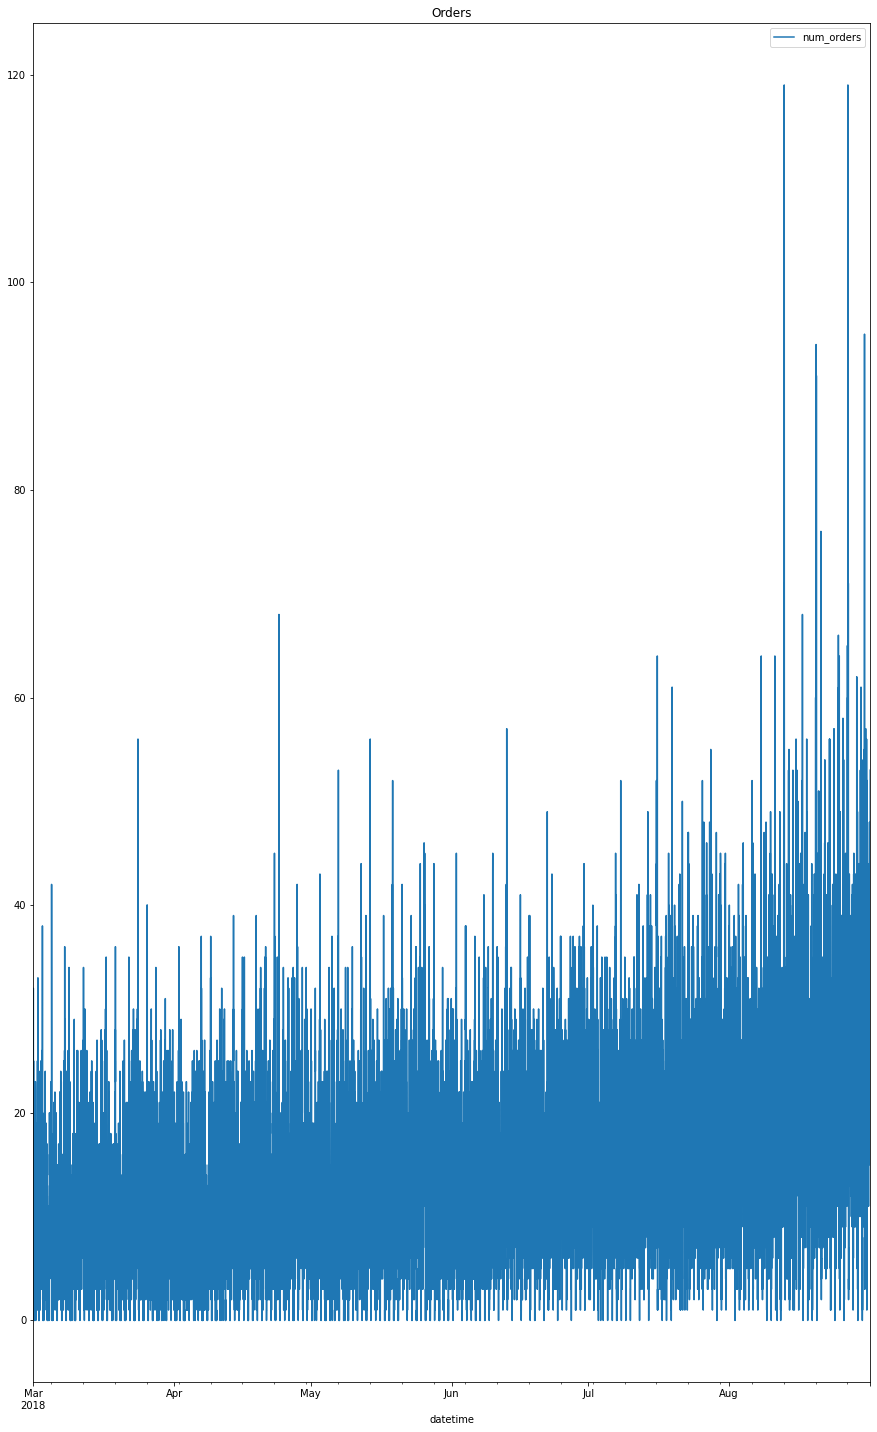

In [8]:
taxi_dataset.plot(figsize=(15,25))
plt.title("Orders")

In [9]:
taxi_dataset = taxi_dataset.resample('1H').sum()

In [10]:
def decompose(data):
    result_decompose = seasonal_decompose(data)
    plt.figure(figsize=(6,10))

    plt.subplot(411)
    result_decompose.trend.plot(ax=plt.gca())
    plt.title('Trend')

    plt.subplot(412)
    result_decompose.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')

    plt.subplot(413)
    result_decompose.resid.plot(ax=plt.gca())
    plt.title('Residuals')

    plt.tight_layout()

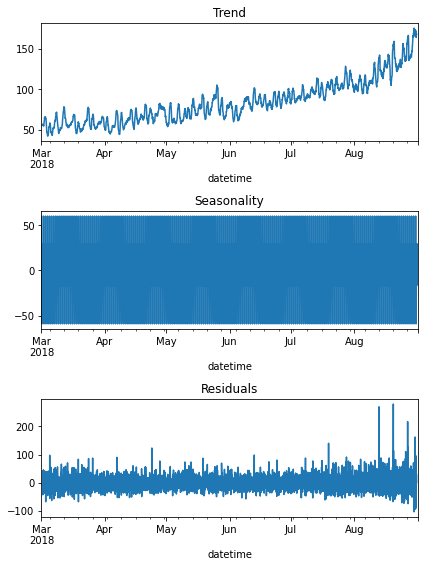

In [11]:
decompose(taxi_dataset)

#### Conclusion
We see unsteady-state process, as avg amount of orders is growing.<br>
There is a growth of orders in a period March - September.<br>
Residuals are stationary. Picks in the end of period<br>

*Adding features*

In [12]:
def make_features(data, max_lag, rolling_size):
    taxi_dataset_copy = taxi_dataset.copy()
    taxi_dataset_copy['days'] = data.index.day
    taxi_dataset_copy['dayofweek'] = data.index.dayofweek

    taxi_dataset_copy['lag_1'] = data['num_orders'].shift()
    for lag in range(24, max_lag + 1, 24):
        taxi_dataset_copy['lag_{}'.format(lag-1)] = data['num_orders'].shift(lag-1)
        taxi_dataset_copy['lag_{}'.format(lag+1)] = data['num_orders'].shift(lag+1)
        taxi_dataset_copy['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    taxi_dataset_copy['rolling_mean'] = data['num_orders'].shift(24).rolling(rolling_size).mean()

    taxi_dataset_copy = taxi_dataset_copy.dropna()
    return taxi_dataset_copy


*Spliting data*

In [13]:
def split_data(data, return_train_valid = False):
    train_valid, test = train_test_split(
        data,
        shuffle=False,
        test_size=0.1)

    train_valid = train_valid.dropna()
    train, valid = train_test_split(
        train_valid,
        shuffle=False,
        test_size=0.1)

    if return_train_valid:
        return train_valid, test
    return train, valid

*Defining features and target for Train and Test Sets*

In [14]:
def feat_target(train, test):
    features_train = train.drop('num_orders', axis=1)
    features_test = test.drop('num_orders', axis=1)
    target_train = train['num_orders']
    target_test = test['num_orders']
    return features_train, target_train, features_test, target_test

*Prepearing features*

In [15]:
def features_prepeared(data, max_lag, rolling_size, return_tv = False):
    data_temp = make_features(
        data,
        max_lag,
        rolling_size)

    train, test = split_data(
        data_temp,
        return_tv)
    features_train, target_train, features_test, target_test = feat_target(train, test)
    return features_train, target_train, features_test, target_test

### Conclusion

Created new features: days and day of weak.<br>
Split data for train and test.<br>
Defining features and target for Train and Test Sets.<br>
Prepared features.


## Models<a href='models'></a>

In [16]:
def linReg(features_train, target_train, features_test, target_test):
    model = LinearRegression()
    model.fit(features_train, target_train)
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)
    return pred_train, pred_test


In [17]:
def modeling(data, max_lag, rolling_size, return_tv=False):
    features_train, target_train, features_test, target_test = features_prepeared(data, max_lag, rolling_size, return_tv)

    pred_train, pred_test = linReg(
        features_train,
        target_train,
        features_test,
        target_test)

    rmse_test = mean_squared_error(target_test, pred_test)**0.5
    rmse_train = mean_squared_error(target_train, pred_train)**0.5
    return rmse_train, rmse_test

In [18]:
flag = 100
best_roll = 0
rmse_train = 0
for i in range (1, 200, 1):
    rmse_train, rmse_valid = modeling(taxi_dataset, 168 , i)
    if flag > rmse_valid:
        flag = rmse_valid
        best_roll = i
        print(rmse_train, flag, best_roll)
print('The best size of sliding window is: ', best_roll)

20.296627888875143 28.969809654882976 1
20.293726429843524 28.969367514204276 8
The best size of sliding window is:  8


In [19]:
features_tv, target_tv, features_test, target_test = features_prepeared(taxi_dataset, 168,8, return_tv=True)

*Linear Regression*

In [20]:

model_linear = LinearRegression()
model_forest = RandomForestRegressor(random_state = 12345, n_jobs=-1)
model_tree = DecisionTreeRegressor(random_state = 12345)

In [21]:
def cr_val_sc(model, features, target):
    score = cross_val_score(model, features, target, cv=5, scoring = 'neg_mean_squared_error')
    final_score = score.mean()
    return abs(final_score)**0.5

In [22]:
print('RMSE of LinearRegression: ',cr_val_sc(model_linear, features_tv, target_tv))

RMSE of LinearRegression:  21.592874608544513


In [23]:
params_forest = {
    'n_estimators': [50,300,50],
    'max_depth':[5,15],
    'max_features' : [1,20, 2]
}

In [24]:
params_tree = {
    'max_depth':[1,20]
}

*Decision Tree Regressor*

In [25]:
CV_tree = GridSearchCV(model_tree,
                       param_grid=params_tree,
                       scoring = 'neg_mean_squared_error',
                       cv=5)
CV_tree.fit(features_tv, target_tv)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'max_depth': [1, 20]},
             scoring='neg_mean_squared_error')

In [26]:
print('The best RMSE:', abs(CV_tree.best_score_)**0.5)
print('With parameters', CV_tree.best_params_)

The best RMSE: 31.024223547015147
With parameters {'max_depth': 20}


*Random Forest Regressor*

In [ ]:
CV_forest = GridSearchCV(model_forest,
                         param_grid=params_forest,
                         scoring='neg_mean_squared_error',
                         cv=5)
CV_forest.fit(features_tv, target_tv)

In [28]:
print('The best RMSE:', abs(CV_forest.best_score_)**0.5)
print('With parameters', CV_forest.best_params_)

The best RMSE: 22.212759976521312
With parameters {'max_depth': 15, 'max_features': 20, 'n_estimators': 300}


#### Conclusion

The best size of sliding window is:  8

|Model| RMSE|
|---|---|
|LR|21|
|RF|22|
|DT|31|

The best RMSE is for Linear Regression. Not big difference with Random Forest Classifier. To choose better we can check which one is faster(on my computer winner is LR))

### Training Best Model on Test Set<a href='test_set'></a>

In [29]:
model_best = LinearRegression()
model_best.fit(features_tv, target_tv)
pred_train = model_best.predict(features_tv)
pred_test = model_best.predict(features_test)

In [30]:
rmse_test = mean_squared_error(target_test, pred_test)**0.5
rmse_train = mean_squared_error(target_tv, pred_train)**0.5

print('RMSE for Train Set is:', rmse_train)
print('RMSE for Test Set is: ', rmse_test)

RMSE for Train Set is: 21.2984860190179
RMSE for Test Set is:  35.28390357992546


### Conclusion

Linear Regression has RMSE less than 48 which is according to the task
